In [0]:
#Import libraries

import os
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

#Download dataset

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [0]:
# normalize inputs from 0-255 to 0.0-1.0
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255.0
x_test = x_test / 255.0

In [0]:
x_train=np.dot(x_train[...,:3], [0.299, 0.587, 0.114])
x_test=np.dot(x_test[...,:3], [0.299, 0.587, 0.114])
# add empty color dimension
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [113]:
#Split the dataset into train and valid
s = StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=1/6)
train_index, valid_index = next(s.split(x_train, y_train))
x_valid, y_valid = x_train[valid_index], y_train[valid_index]
x_train, y_train = x_train[train_index], y_train[train_index]
print(x_train.shape, x_valid.shape, x_test.shape)

(41666, 32, 32, 1) (8334, 32, 32, 1) (10000, 32, 32, 1)


In [114]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
model.add(tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
model.add(tf.keras.layers.Conv2D(256, (5, 5), padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256))
model.add(tf.keras.layers.Activation('elu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10))
model.add(tf.keras.layers.Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_v1_48 (B (None, 32, 32, 1)         4         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 32, 32, 64)        1664      
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_55 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization_v1_49 (B (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 16, 16, 128)       204928    
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 8, 8, 128)         0         
__________

In [115]:
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    )
)
tpu_model.compile(
    optimizer=tf.train.AdamOptimizer(learning_rate= 0.001 ),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['sparse_categorical_accuracy']
)

INFO:tensorflow:Querying Tensorflow master (grpc://10.32.169.98:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 10747285140552251337)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 14634709620600469487)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 6878331701309248351)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 4332928681873063008)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 5846955643240016812)
INFO:tensorflow:*** Available Device: _DeviceAttributes(

In [116]:
%%time

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)
 
    
batch_size=128
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2, verbose=1)
history=tpu_model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    epochs=30,
    steps_per_epoch=int(np.ceil(x_train.shape[0] / batch_size)),
    validation_data=(x_valid, y_valid),callbacks=[early_stop]
)

Epoch 1/30
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(16,), dtype=tf.int32, name='core_id_200'), TensorSpec(shape=(16, 32, 32, 1), dtype=tf.float32, name='batch_normalization_v1_48_input_10'), TensorSpec(shape=(16, 1), dtype=tf.int32, name='activation_39_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for batch_normalization_v1_48_input
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 38.33244180679321 secs
INFO:tensorflow:Setting weights on TPU model.
124/326 [==========>...................] - ETA: 1:54 - loss: 3.0517 - sparse_categorical_accuracy: 0.1744INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(8,), dtype=tf.int32, name='core_id_200'), TensorSpec(shape=(8, 32, 32, 1), dtype=tf.float32, name='batch_normalization_v1_48_input_10'), TensorSpec(shape=(8, 1), dtype=tf.int32, name='activation_39_targe

INFO:tensorflow:Copying TPU weights to the CPU


<Figure size 288x216 with 0 Axes>

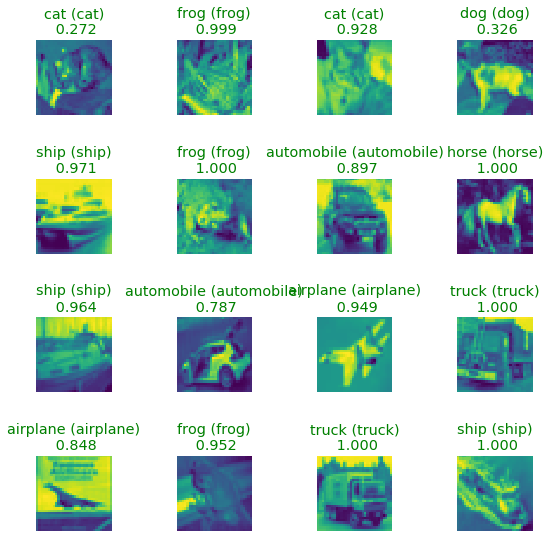

In [118]:
LABEL_NAMES=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

cpu_model = tpu_model.sync_to_cpu()

from matplotlib import pyplot
%matplotlib inline

def plot_predictions(images, predictions, true_labels):
  n = images.shape[0]
  nc = int(np.ceil(n / 4))
  fig = pyplot.figure(figsize=(4,3))
  # axes = fig.add_subplot(nc, 4)
  f, axes = pyplot.subplots(nc, 4)
  f.tight_layout()
  for i in range(nc * 4):
    y = i // 4
    x = i % 4
    axes[x, y].axis('off')
    
    label = LABEL_NAMES[np.argmax(predictions[i])]
    confidence = np.max(predictions[i])
    if i > n:
      continue
    axes[x, y].imshow(images[i])
    pred_label = np.argmax(predictions[i])
    axes[x, y].set_title("{} ({})\n {:.3f}".format(
      LABEL_NAMES[pred_label], 
      LABEL_NAMES[true_labels[i][0]],
      confidence
    ), color=("green" if true_labels[i] == pred_label else "red"))
  pyplot.gcf().set_size_inches(8, 8)  

plot_predictions(
    np.squeeze(x_test[:16]), 
    cpu_model.predict(x_test[:16]),
    y_test[:16]
)

In [119]:
%%time
# Evaluate the model on valid set
score = cpu_model.evaluate(x_valid, y_valid, verbose=0)

# Print test accuracy
print('\n', 'Valid accuracy:', score[1])


 Valid accuracy: 0.78173745
CPU times: user 1.73 s, sys: 92.5 ms, total: 1.82 s
Wall time: 22 s


In [120]:
%%time
# Evaluate the model on test set
score = cpu_model.evaluate(x_test, y_test, verbose=0)

# Print test accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.7817
CPU times: user 2.01 s, sys: 64.2 ms, total: 2.07 s
Wall time: 5.59 s


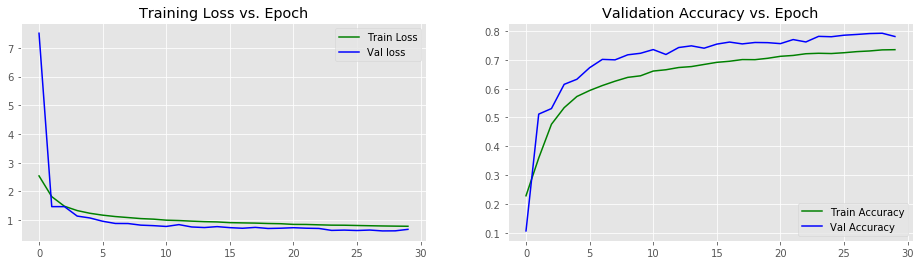

In [117]:
# For visually better looking plots
import matplotlib.pyplot as plt
# Changing default figure size for properly accomodating images
from pylab import rcParams
rcParams['figure.figsize'] = (16, 4)
plt.style.use('ggplot')

f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.set_title('Training Loss vs. Epoch')
ax2.set_title('Validation Accuracy vs. Epoch')

ax1.plot(history.history['loss'], color='green', label='Train Loss')
ax1.plot(history.history['val_loss'], color='blue', label='Val loss')

ax2.plot(history.history['sparse_categorical_accuracy'], color='green', label='Train Accuracy')
ax2.plot(history.history['val_sparse_categorical_accuracy'], color='blue', label='Val Accuracy')

ax1.legend(loc='upper right')
ax2.legend(loc='lower right')
plt.show()

